In [151]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Import data

In [152]:
## Defined functions

def convert_drugs(value):
    """
    Clean up weird values for drugs text box
    :param value: value to convert
    :return: categegorical value
    """
    if value == "Caffeine (energy drinks/coffee)" or \
        value == "Caffeine (energy drinks/coffee), Kohvi on elu, kohvi on armastus :) " or \
        value == "Herbal tea" or value == 'herbal tea' or value == "tee":
        return "Caffeine"
    elif value.startswith("Ei") or value == "No" or value == "no" or value == "food" or value == "sweets":
        return "No"
    return value


In [153]:
## Read data in

general = pd.read_csv("out_general.csv", names=["row", "ts", "user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"])
common = pd.read_csv("out_common.csv", names=["ts", "user_id", "res_number", "res_reaction", "res_visual", "hungry", "sleepy", "time_sleep", "time_wake", "stress",
                                              "fatigue_mental", "fatigue_physical", "drugs"], header=0, 
                     converters={'ts':lambda v: pd.Timestamp(v), 
                                 'time_sleep':lambda v: pd.to_timedelta(v), 
                                 'time_wake':lambda v: pd.to_timedelta(v),
                                 'drugs': convert_drugs},
                     dtype={'hungry':'category', 
                            'sleepy':'category', 
                            'stress':'category', 
                            'fatigue_mental':'category', 
                            'fatigue_physical':'category'})

common["drugs"] = common["drugs"].astype('category')

In [159]:
## User related modifications

pd.set_option("mode.chained_assignment", None)

## Alter user_ids

common["user_id"].loc[
    (common["user_id"] == 29) | 
    (common["user_id"] == 33) | 
    (common["user_id"] == 34) | 
    (common["user_id"] == 36)
    ] = 1
    
common["user_id"].loc[
    (common["user_id"] == 37)
    ] = 35
    
common["user_id"].loc[
    (common["user_id"] == 4) |
    (common["user_id"] == 7)
    ] = 13


## Delete not suitable users

common = common[
    (common["user_id"] != 9) &
    (common["user_id"] != 10) &
    (common["user_id"] != 14) &
    (common["user_id"] != 18) &
    (common["user_id"] != 30) &
    (common["user_id"] != 31) &
    (common["user_id"] != 38) 
    ]


In [156]:
common.dtypes

ts                   datetime64[ns]
user_id                       int64
res_number                    int64
res_reaction                  int64
res_visual                    int64
hungry                     category
sleepy                     category
time_sleep          timedelta64[ns]
time_wake           timedelta64[ns]
stress                     category
fatigue_mental             category
fatigue_physical           category
drugs                      category
dtype: object

### Add times from waking up

In [157]:
common["drugs"].cat.categories

Index(['Alcohol', 'Caffeine', 'No'], dtype='object')

In [160]:
common["user_id"].value_counts()
## So many user_ids with only one entry? 
## Some of these should be removed before => Can't be done without knowing the names. 

6     17
11    14
16    14
23    14
2     14
13    13
28    12
15    12
8     12
3     12
12    11
19    11
21     9
24     9
25     9
26     9
27     9
17     8
1      8
20     8
5      7
32     5
22     4
35     3
Name: user_id, dtype: int64

In [42]:
hungry_level_1 = common.loc[common["hungry"] == '1', ["res_number", "res_reaction", "res_visual"]]
hungry_level_3 = common.loc[common["hungry"] == '3', ["res_number", "res_reaction", "res_visual"]]

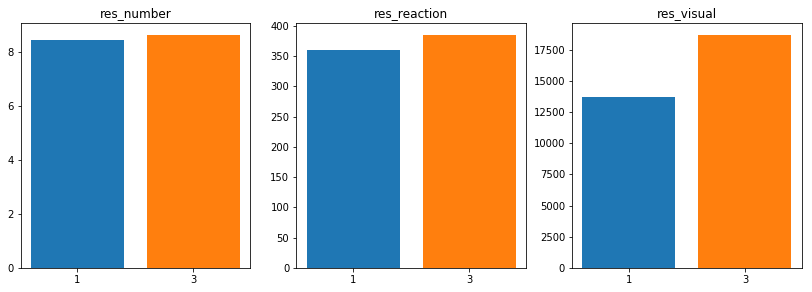

In [70]:
def draw_bar_plot(plot, title, x_axis_list, y_axis_list):
    plot.set_title(title)

    for i in range(0, len(x_axis_list)):
        plot.bar(x_axis_list[i], y_axis_list[i], align = "center")
        
        
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize = (14, 4.5)) 

draw_bar_plot(plt1, "res_number", ['1', '3'], [hungry_level_1["res_number"].mean().round(2), hungry_level_3["res_number"].mean().round(2)])
draw_bar_plot(plt2, "res_reaction", ['1', '3'],  [hungry_level_1["res_reaction"].mean().round(2), hungry_level_3["res_reaction"].mean().round(2)])
draw_bar_plot(plt3, "res_visual", ['1', '3'], [hungry_level_1["res_visual"].mean().round(2), hungry_level_3["res_visual"].mean().round(2)])